# Sarcasm detection

Dataset original source:

- [Kaggle](https://www.kaggle.com/datasets/rmisra/news-headlines-dataset-for-sarcasm-detection)

Build a predictive model

- Compare: NB, KNN, SVM

Theorical sources

- [NB](https://en.wikipedia.org/wiki/Naive_Bayes_classifier)
- [KNN](https://www.codecademy.com/learn/introduction-to-supervised-learning-skill-path/modules/k-nearest-neighbors-skill-path/cheatsheet)
- [SVM](https://es.wikipedia.org/wiki/M%C3%A1quinas_de_vectores_de_soporte)

Sklearn algorithm references

- [Column Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html)
- [One Hot Encoder](https://datagy.io/sklearn-one-hot-encode/)
- [Text feature extraction](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
- [NB](https://scikit-learn.org/stable/modules/naive_bayes.html)
- [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [SVM](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

## Import the libraries

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wilber.bermeo.quito\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\wilber.bermeo.quito\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Import the data

In [3]:
dataset_name = 'Sarcasm_Headlines_Dataset.json'
df = pd.read_json(dataset_name, lines=True)

In [4]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## Exploratory data analysis

In [5]:
df.shape

(26709, 3)

In [6]:
df.isna().sum()

article_link    0
headline        0
is_sarcastic    0
dtype: int64

### Drop duplicate headlines samples

In [7]:
# I notice that there are many headlines repeated in the data set
df['headline'].duplicated().sum()

107

In [8]:
# Index of the elements duplicated, except for the occurence
df[df['headline'].duplicated()].index

Int64Index([ 1091,  2265,  2975,  3802,  4605,  5154,  5789,  6383,  6642,
             6685,
            ...
            25115, 25118, 25855, 25995, 26026, 26121, 26156, 26353, 26500,
            26615],
           dtype='int64', length=107)

In [9]:
df = df.drop(df[df['headline'].duplicated()].index, axis=0)

In [10]:
df['headline'].duplicated().sum()

0

### Sarcastic distribution

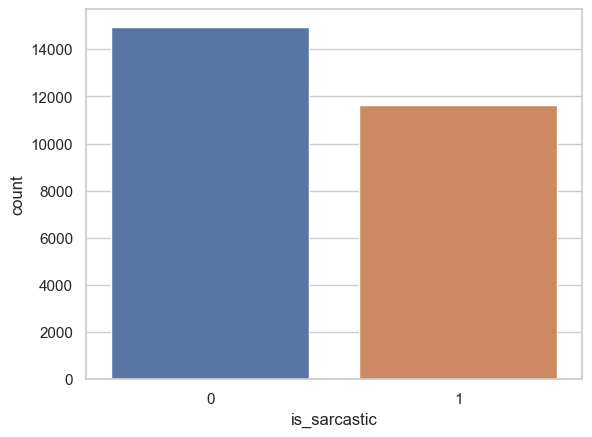

In [11]:
# here I notice that the dependent variable is unbalanced. Not that much yet unbalanced
sns.set_theme(style='whitegrid')
ax = sns.countplot(x='is_sarcastic', data=df)

### Origin transmitter distribution

In [12]:
get_transmitter = lambda source : source.split('.')[1]
df['transmitter'] = df['article_link'].apply(get_transmitter)

In [13]:
df.head()

,article_link,headline,is_sarcastic,transmitter
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,theonion
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,theonion
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost


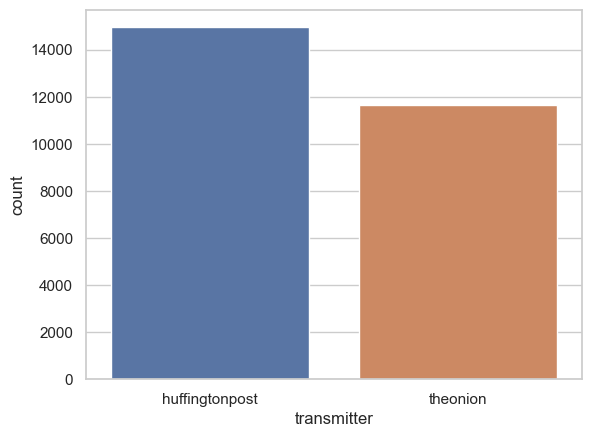

In [14]:
# here I notice that the dependent variable is unbalanced. Not that much yet unbalanced
sns.set_theme(style='whitegrid')
ax = sns.countplot(x='transmitter', data=df)

### Sarcasm of the transmitter

In [40]:
group_df = df.groupby(by=['is_sarcastic', 'transmitter'], as_index=False).count()
pivot = group_df.pivot(index='is_sarcastic', columns='transmitter', values='headline')
pivot.fillna(0)

transmitter,huffingtonpost,theonion
is_sarcastic,,
0,14951.0,0.0
1,0.0,11651.0


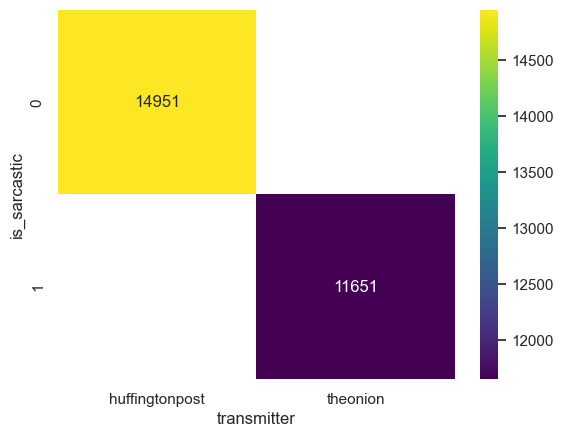

In [41]:
# with this plot I can see that theonion is a web page that only generates sarcastic headlines
# as huffingtonpost generates trustfull text without second meanings
sns.set_theme(style='whitegrid')
ax = sns.heatmap(pivot, annot=True, fmt="g", cmap='viridis')

## Preprocessing

In [ ]:
def denoise(text):
    tokenizer = lambda text : nltk.word_tokenize(text)
    parse_url = lambda text : re.sub('http\S+' , '' , text)
    strip = lambda text : text.strip()
    to_raw = lambda text : re.sub('[^a-z\s]', '', text)  #drop any symbol except a-z
    
    def to_lower_case(words):
        return [w.lower() for w in words]
        
    def drop_urls(words):
        return [re.sub('http\S+', '', w) for w in words]

    def drop_puntuations(words): 
        re_punc = re.compile('[%s]' % re.escape(string.punctuation))
        return [re_punc.sub('', w) for w in words] 
        
    def drop_stopwords(words):
        sw = set(stopwords.words('english'))
        return [w for w in words if w not in sw]

    ws = tokenizer(text)
    ws = [to_lower_case(w) for w in ws]
    ws = [parse_url(w) for w in ws]
    ws = [strip(w) for w in ws]
    ws = [to_raw(w) for w in ws]
    ws = [w for w in ws if w not in en_stop]
    ws = [w for w in ws if wordnet.synsets(w)] # known synomous of this word
    
    return ' '.join(ws).strip()
    
df['cleaned_headline'] = df['headline'].apply(denoise)

df[['headline', 'cleaned_headline']].head()

## Visualize headline tokens with WordCloud

In [ ]:
from wordcloud import WordCloud 

In [ ]:
non_sarcastic_headline_df = df[df['is_sarcastic'] == 0]['cleaned_headline']
sarcastic_headline_df = df[df['is_sarcastic'] == 1]['cleaned_headline']

non_sarcastic_headline_np = non_sarcastic_headline_df.values
sarcastic_headline_np = sarcastic_headline_df.values

In [ ]:
text = ' '.join(non_sarcastic_headline_np)
plt.figure(figsize = (10,10))
wc = WordCloud(width = 2000 , height = 1000 , max_words = 500).generate(text)
plt.axis('off')
plt.title('Worcloud of non sarcastic words')
plt.imshow(wc , interpolation = 'bilinear')

In [ ]:
text = ' '.join(sarcastic_headline_np)
plt.figure(figsize = (10,10))
wc = WordCloud(width = 2000 , height = 1000 , max_words = 500).generate(text)
plt.axis('off')
plt.title('Worcloud of sarcastic words')
plt.imshow(wc , interpolation = 'bilinear')

## The headline transmitter

In [ ]:
extract_transmitter = lambda source : source.split('.')[1]
df['transmitter'] = df['article_link'].apply(extract_transmitter)

In [ ]:
df.drop('article_link', inplace=True, errors='ignore', axis=1)
df.head()

In [ ]:
# todo: encode transmitter columns
df['transmitter'].unique()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
transmitter_transformed = ohe.fit_transform(df[['transmitter']])
print(ohe.categories_)
print(transmitter_transformed.toarray()[0:5])
# this could be a way to transform this columns but
# I'll use ColumnTransfomer class to acomplish this
# df[ohe.categories_[0]] = transmitter_transformed.toarray()
# df.head()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

transformer = make_column_transformer(
    (OneHotEncoder(), ['transmitter']),
    remainder='passthrough')

transformed = transformer.fit_transform(df)

transformed_df = pd.DataFrame(
    transformed, 
    columns=transformer.get_feature_names_out()
)

transformed_df.head()